In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

all_features = []

In [ ]:
# range: [0, 23]
feature_id = 0
epochs = 50
model_id = 0

In [4]:
possible_columns = [
    "服裝部位 Clothing Part",
    "上半身 衣服種類 Top Clothing Type",
    "下半身衣服種類 Bottom Clothing Type",
]

all_features = pd.read_csv("feature_list.csv")["name"].to_list()
target_feature = all_features[feature_id]
print("target feature:", target_feature)

target feature: Shirt


In [5]:
from PIL import Image


def validate_image(row):
    filepath = row["filepath"]
    try:
        # Try to open the image file
        with Image.open(filepath) as img:
            img.verify()  # Check if the file is a valid image
        return True
    except (IOError, OSError):
        # If the image is not valid, return False
        return False

In [6]:
# Load the CSV file
csv_file = "./processed.csv"
df = pd.read_csv(csv_file)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Base directory where the images are stored
image_dir = "./clothes_data"

# Add the full path to each image
df["filepath"] = df["照片 Picture"].apply(lambda x: os.path.join(image_dir, f"{x}"))
print(df["filepath"])

# remove invalid datas
df = df[df.apply(validate_image, axis=1)].reset_index(drop=True)
# take % 10 == 0's data as test so remove them
df = df.drop(df.index[df.index % 10 == 0])

df["result"] = df[target_feature]
print("total data:", len(df.index))

0       ./clothes_data\image_00000.jpg
1       ./clothes_data\image_00001.jpg
2       ./clothes_data\image_00002.jpg
3       ./clothes_data\image_00003.jpg
4       ./clothes_data\image_00004.jpg
                     ...              
3241    ./clothes_data\image_03241.jpg
3242    ./clothes_data\image_03242.jpg
3243    ./clothes_data\image_03243.jpg
3244    ./clothes_data\image_03244.jpg
3245    ./clothes_data\image_03245.jpg
Name: filepath, Length: 3246, dtype: object
total data: 2921


In [7]:
img_height, img_width = 180, 180


def load_and_preprocess_image(filepath):
    img = load_img(filepath, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract features and labels
train_images = np.array([load_and_preprocess_image(fp) for fp in train_df["filepath"]])
train_labels = train_df["result"].values

val_images = np.array([load_and_preprocess_image(fp) for fp in val_df["filepath"]])
val_labels = val_df["result"].values

In [9]:
model = models.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # Sigmoid for binary classification
    ]
)

c:\Users\doo12\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
history = model.fit(
    train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs
)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.9068 - loss: 0.3669 - val_accuracy: 0.9026 - val_loss: 0.3001
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 318ms/step - accuracy: 0.9251 - loss: 0.2573 - val_accuracy: 0.9026 - val_loss: 0.2745
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 25s 335ms/step - accuracy: 0.9159 - loss: 0.2470 - val_accuracy: 0.9026 - val_loss: 0.2631
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 325ms/step - accuracy: 0.9207 - loss: 0.2304 - val_accuracy: 0.9026 - val_loss: 0.2943
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 327ms/step - accuracy: 0.9026 - loss: 0.2543 - val_accuracy: 0.9026 - val_loss: 0.2554


In [15]:
loss, accuracy = model.evaluate(val_images, val_labels)
name = "model_feature_" + str(feature_id) + "_" + str(model_id) + ".keras"


print(f"{name}: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9016 - loss: 0.2594
model_feature_0_1.keras: 0.9026


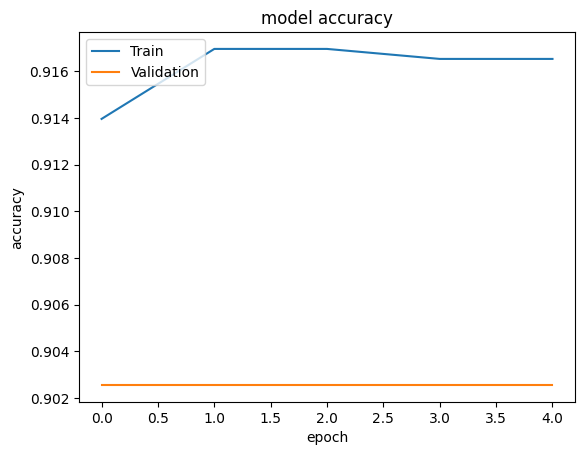

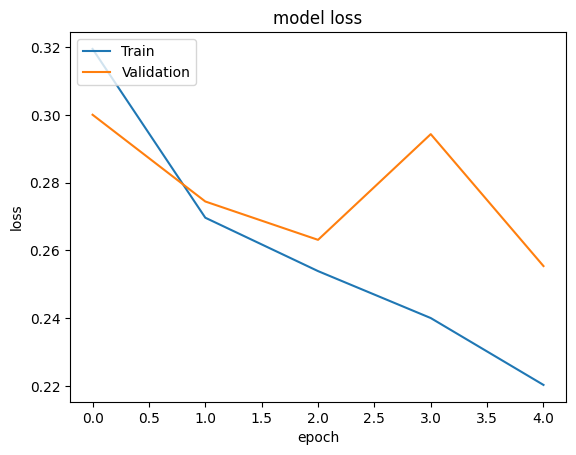

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [14]:
model_folder = "models"
model.save(os.path.join(model_folder, name))